## Install libraries

In [63]:
!pip -q install cartopy
!pip -q install netCDF4
!pip -q install s3fs

## Download GOES-16 ABI L1b file

In [15]:
import s3fs
import datetime

fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

abidt = datetime.datetime(2024,8,13,18,40)

file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadF/%Y/%j/%H/*C13*_s%Y%j%H%M*.nc'))
_ = fs.download(file_location[0], 'test.nc')

Here is the code to compute the satellite-zenith angle. In requires latitudes, longitudes, and the satellite positional longitude (`satlon`, default = -75.0).

In [16]:
import numpy as np

def sat_zen_angle(xlat, xlon, satlat=0, satlon=-75.0):

    """
    Calculate the satellite-zenith or satellite-viewing angle
    of given geographical coordinates given the position of a geostationary satellite.

    Args:
      xlat: Numpy array (or list) of latitude coordinates.
      xlon: Numpy array (or list) of longitude coordinates.
      satlat: Satellite latitude, default 0.
      satlon: Satellite longitude, default -75.0.

    Returns:
      Numpy array of satellite zenith angles.

    """

    DTOR = np.pi / 180.0

    if isinstance(xlat, list):
        xlat = np.array(xlat)
    if isinstance(xlon, list):
        xlon = np.array(xlon)

    lon = (xlon - satlon) * DTOR
    lat = (xlat - satlat) * DTOR

    beta = np.arccos(np.cos(lat) * np.cos(lon))
    sin_beta = np.sin(beta)

    zenith = np.arcsin(
        42164.0 * sin_beta / np.sqrt(1.808e09 - 5.3725e08 * np.cos(beta))
    )

    zenith = zenith / DTOR

    return zenith


## Compute the latitudes and longitudes

The function below will compute latitudes and longitudes for a GOES-R file, which has a fixed-grid format.

In [19]:
def calculate_abi_degrees(file_id):

    """
    Calculate latitude and longitude from GOES ABI fixed grid projection data
    GOES ABI fixed grid projection is a map projection relative to the GOES satellit
    Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
    See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculation
    "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library
    This function was created by NOAA/NESDIS/STAR Aerosols and Atmospheric Composition Science Team.
    """

    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)

    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    return abi_lat, abi_lon

## Compute and visualize satellite-zenith angle

In [42]:
# Open the ABI L1b file

from netCDF4 import Dataset
nc = Dataset('test.nc', 'r')
lats, lons = calculate_abi_degrees(nc)
# Get projection coords for plotting
projx = nc.variables['x'][:] * nc.variables['goes_imager_projection'].perspective_point_height
projy = nc.variables['y'][:] * nc.variables['goes_imager_projection'].perspective_point_height
nc.close()

# Compute SZA

sza = sat_zen_angle(xlon=lons, xlat=lats, satlon=-75)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


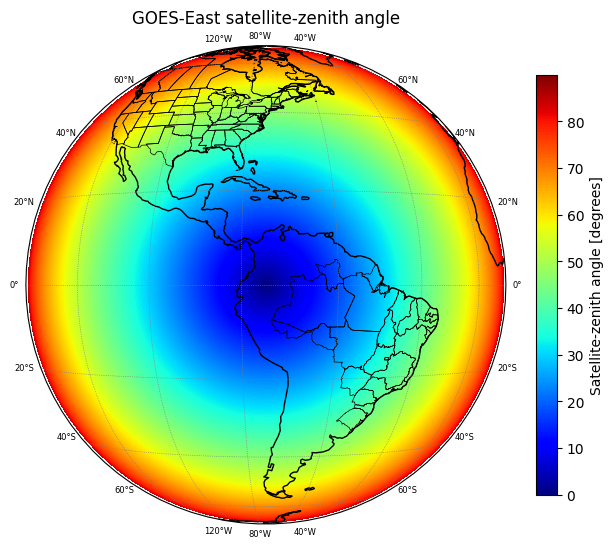

In [62]:
# Visualize

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

state_borders = cfeature.STATES.with_scale("50m")

crs = ccrs.Geostationary(central_longitude=-75.0)

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], projection=crs)
extent = [projx.min(), projx.max(), projy.min(), projy.max()]
im = ax.imshow(sza, cmap='jet', extent=extent, transform=crs)
ax.coastlines()
ax.add_feature(state_borders, edgecolor="black", linewidth=0.5)
plt.title('GOES-East satellite-zenith angle')

gl = ax.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle=":",
)
# Customize the gridline labels
gl.xlocator = mticker.FixedLocator([-120, -100, -80, -60, -40, -20])
#gl.xformatter = LONGITUDE_FORMATTER
# only display given longitudes
gl.xformatter = plt.FuncFormatter(lambda x, pos: f'{np.abs(int(x))}°W' if x in [-120, -80, -40] else '')
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Satellite-zenith angle [degrees]')

Now we can plainly see how satellite-zenith angle increases from 0 to 90 degrees from nadir to the limb, and increases very rapidly once